

***This notebook owes to [beluga](https://www.kaggle.com/gaborfodor)'s kernels, especialy [this one](https://www.kaggle.com/gaborfodor/exploratory-data-analysis-external-data), for the most part.***

**If you use Jupyter Lab, you have to install the renderer extensions for plotly.**
- https://github.com/jupyterlab/jupyter-renderers
- https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension

**If you want to export Plotly graphs as static images, you have to install orca and psutil.**
- https://github.com/plotly/orca#installation
- https://plot.ly/python/static-image-export/

In [1]:
import os
import numpy as np
import pandas as pd
import warnings; warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
sns.set_palette(sns.color_palette('tab20', 20))

import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)  # You can plot your graphs offline inside a Jupyter Notebook Environment.
print(plotly.__version__)

3.4.1


## Helper Functions for Plotly

In [2]:
## Colors of Viridis: https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
C = ['#3D0553', '#4D798C', '#7DC170', '#F7E642']

## export plotly graphs as static images
def write_image(fig, filename, save=False, to_image=False):
    """
    ```
    # for displaying images
    img_bytes = write_image(fig, "plot.svg", to_image=True)
    from IPython.display import SVG, display  # import Image when PNG
    display(SVG(img_bytes))
    ```
    """
    import plotly.io as pio
    if save:
        if not os.path.exists("svgs")==True:
            os.mkdir("svgs")
        if not '.svg' in filename: 
            filename = filename + ".svg"
        pio.write_image(fig, 'svgs/{}'.format(filename))
    if to_image:
        if not '.svg' in filename: 
            filename = filename + ".svg"
        return pio.to_image(fig, format="svg")

## Title, X-Axis Title, Y-Axis Title
def plotly_layout(title=None, xtitle=None, ytitle=None):
    return go.Layout(title=title,
                     xaxis=dict(title=xtitle, ticklen=5, zeroline=False, gridwidth=2),
                     yaxis=dict(title=ytitle, ticklen=5, gridwidth=2))

## Histogram
def plotly_hist(data, col, bin_dict=None, title=None, xtitle=None, ytitle=None):
    trace = [
        go.Histogram(
            x=data[col].values,
            histfunc = "count",
            marker=dict(color=C[0]),
            xbins=bin_dict,
        ),
    ]
    layout = plotly_layout(title=title, xtitle=xtitle, ytitle=ytitle)
    fig = go.Figure(data=trace, layout=layout)
    return py.iplot(fig, show_link=False)

## Boxplot
def plotly_boxplot(data, col, title=None, xtitle=None, ytitle=None):
    trace = [
        go.Box(
            y=data[col].values,
            marker=dict(color=C[0]),
        ),
    ]
    layout = plotly_layout(title=title, xtitle=xtitle, ytitle=ytitle)
    fig = go.Figure(data=trace, layout=layout)
    return py.iplot(fig, show_link=False)

## Barplot
def plotly_barplot(data, xcol, ycol, title=None, xtitle=None, ytitle=None):
    trace = [
        go.Bar(
            x=cat_to_str(data[xcol].values),
            y=data[ycol].values,
            text=data[ycol].values,
            textposition='auto',
            marker=dict(
                color=data[ycol].values,
                colorscale='Viridis',
                showscale=True,
                reversescale=True
            ),
        ),
    ]
    layout = plotly_layout(title=title, xtitle=xtitle, ytitle=ytitle)
    fig = go.Figure(data=trace, layout=layout)
    return py.iplot(fig, show_link=False)

## Countplot
def plotly_countplot(data, col, title=None, xtitle=None, ytitle=None):
    trace = [
        go.Histogram(
            x=data[col].values,
            histfunc = "count",
            marker=dict(color=C[0])
        ),
    ]
    layout = plotly_layout(title=title, xtitle=xtitle, ytitle=ytitle)
    fig = go.Figure(data=trace, layout=layout)
    return py.iplot(fig, show_link=False)

## Scatterplot
def plotly_scatterplot(data, xcol, ycol, size=1, title=None, xtitle=None, ytitle=None):
    trace = [
        go.Scatter(
            x=cat_to_str(data[xcol].values),
            y=data[ycol].values,
            mode='markers',
            marker=dict(sizemode='diameter',
                        sizeref=1,
                        size=data[ycol].values**size,
                        color=data[ycol].values,
                        colorscale='Viridis',
                        reversescale=True,
                        showscale=True
                        ),
            text=cat_to_str(data['day'].values),
        )
    ]
    layout = go.Layout(
        autosize=True,
        title=title,
        hovermode='closest',
        xaxis=dict(title=xtitle, ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title=ytitle, ticklen=5, gridwidth=2),
        showlegend=False
    )
    fig = go.Figure(data=trace, layout=layout)
    return py.iplot(fig, show_link=False)

## Lineplot
def plotly_lineplot(data, xcol, ycol, title=None, xtitle=None, ytitle=None, rangeslider=True, slider_type='date'):
    if rangeslider==True:
        xaxis = dict(title=xtitle, ticklen=5, zeroline=False, gridwidth=2,
                     rangeslider=dict(visible=True), type=slider_type)
    else:
        xaxis = dict(title=xtitle, ticklen=5, zeroline=False, gridwidth=2)
    
    trace = [
        go.Scatter(
            x=data[xcol].values,
            y=data[ycol].values, 
            mode='lines', 
            line=dict(width=5, color=C[0])
        )
    ]
    layout = go.Layout(
        title=title,
        xaxis=xaxis,
        yaxis=dict(title=ytitle, ticklen=5, gridwidth=2))
    fig = go.Figure(data=trace, layout=layout)
    return py.iplot(fig, show_link=False)

**Load Datasets**

In [3]:
## Load dataset with load_dataset function of seaborn: https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv

def cat_to_str(arr):
    return np.array(arr, dtype=str)

def load_titanic():
    data = sns.load_dataset("titanic")
    return data

def load_iris():
    data = sns.load_dataset("iris")
    return data

def load_tips(group=None):
    data = sns.load_dataset("tips")
    if not group==None:
        data = data.groupby(group)["tip"].mean().to_frame().reset_index()
    return data

def load_flights(group=None):
    data = sns.load_dataset("flights")
    if not group==None:
        data = data.groupby([group])["passengers"].sum().to_frame().reset_index()
    return data


load_titanic().head(3)
load_iris().head(3)
load_tips().head(3)
load_flights().head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132


---

## Histogram

In [4]:
load_iris().head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


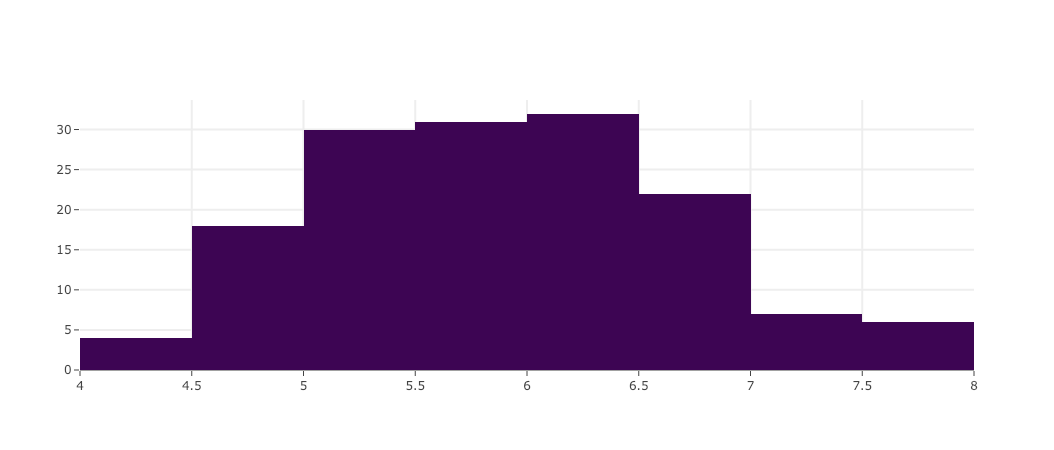

In [5]:
data = load_iris()
plotly_hist(data, "sepal_length")

## Box Plot

In [6]:
load_iris().head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


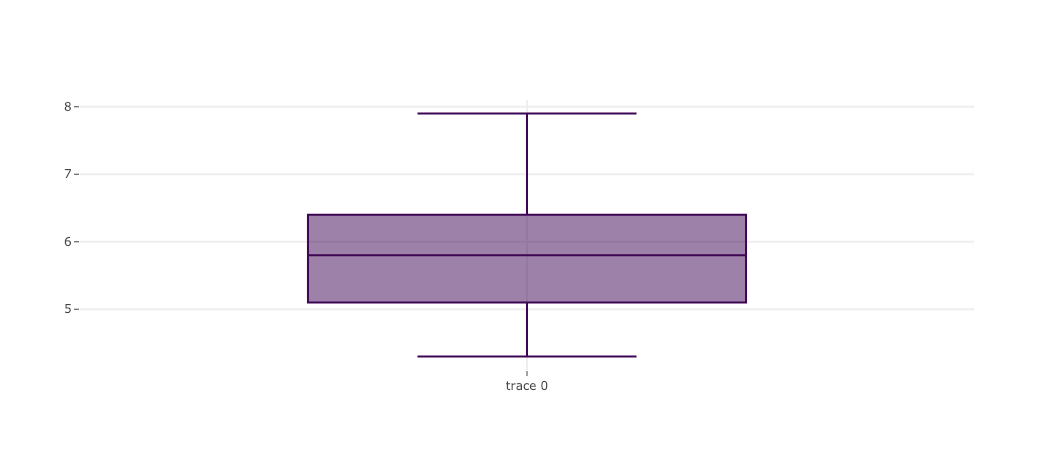

In [7]:
data = load_iris()
plotly_boxplot(data, "sepal_length")

## Bar Plot

In [8]:
load_flights(group="month")

,month,passengers
0,January,2901
1,February,2820
2,March,3242
3,April,3205
4,May,3262
5,June,3740
6,July,4216
7,August,4213
8,September,3629
9,October,3199


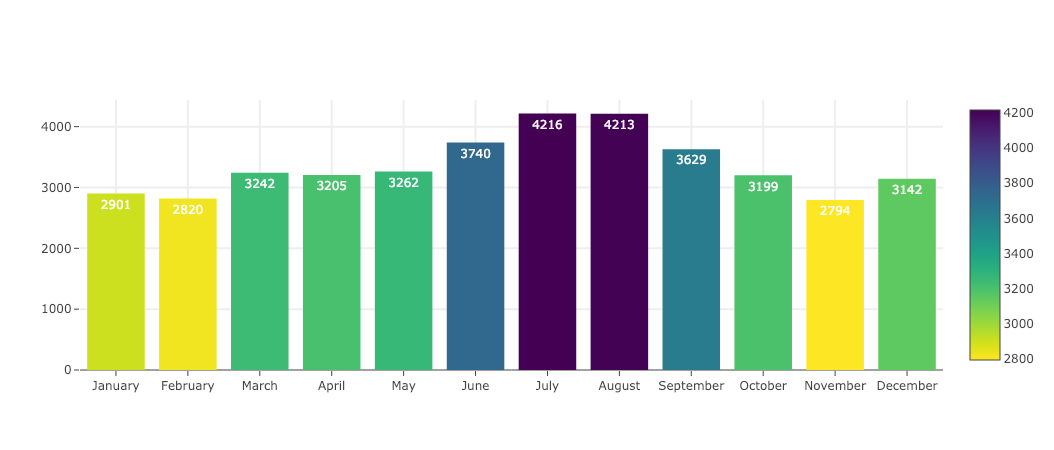

In [9]:
data = load_flights(group="month")
plotly_barplot(data, "month", "passengers")

## Count Plot

In [10]:
load_titanic().head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


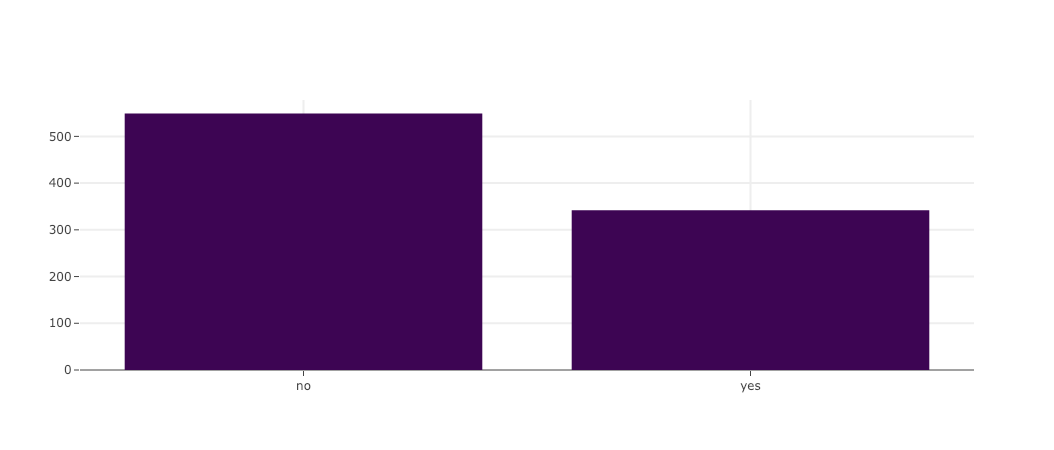

In [11]:
data = load_titanic()
plotly_countplot(data, "alive")

## Scatter Plot

In [12]:
load_tips(group="day")

,day,tip
0,Thur,2.771452
1,Fri,2.734737
2,Sat,2.993103
3,Sun,3.255132


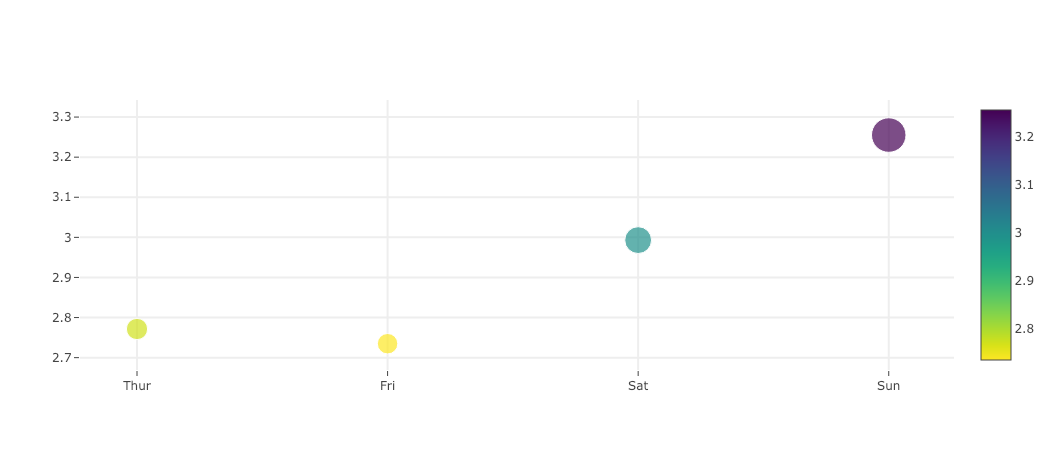

In [13]:
data = load_tips(group="day")
plotly_scatterplot(data, "day", "tip", size=3)

## Line Plot

In [14]:
load_flights().head(3)

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132


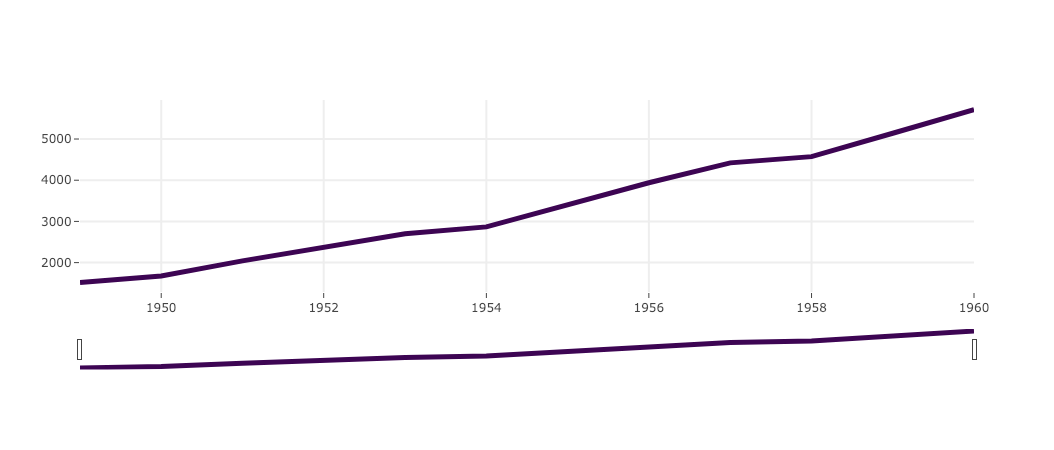

In [15]:
data = load_flights("year")
plotly_lineplot(data, "year", "passengers")

---

## References

- https://www.kaggle.com/gaborfodor/summary-budapest-pythons
- https://www.kaggle.com/gaborfodor/exploratory-data-analysis-external-data
- https://www.kaggle.com/gaborfodor/the-speed-the-acceleration-and-the-collision